# Idoven task

 - Be able to read the ECG files and corresponding annotations
 - Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
 - Identify the heart beat of the signal, average and total heart beat in the signal
 - Identify the complex QRS in the signal and been able to annotate on it
 
As a result we expect a github project with and extructure that will include:
- Reference documentation used
- Jupyter Notebook, in an running environment, Colab, Docker.
- An explanation of the work done and lessons learned.



In [1]:
import ast
import wfdb

import scipy.signal
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The ast (Abstract Syntax Tree) module allows us to interact with Python code and modify it. Python comes with abstract syntax grammar, which is subject to change with every Python release. This module helps applications process trees of syntax and find out what the current syntax grammar looks like programmatically. 

The waveform-database (WFDB) package for Python is a library of tools for reading, writing, and processing physiological signals and annotations, written in the Python programming language.

## 1. Read the ECG files and corresponding annotations

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

The paths to the original record (500 Hz) and a downsampled version of the record (100 Hz) are stored in filename_hr and filename_lr.

filename_lr = 'records100/00000/00001_lr'

filename_hr = 'records500/00000/00001_hr'

In [3]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [4]:
path = '/Users/ilsuleym/Documents/DCNNtest/Idoven/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [5]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [6]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

In [7]:
print(Y.describe())

         patient_id           age           sex       height       weight  \
count  21801.000000  21801.000000  21801.000000  6975.000000  9422.000000   
mean   11250.554287     62.769781      0.479106   166.703226    70.996391   
std     6235.025560     32.307421      0.499575    10.866804    15.878365   
min      302.000000      2.000000      0.000000     6.000000     5.000000   
25%     5975.000000     50.000000      0.000000   160.000000    60.000000   
50%    11419.000000     62.000000      0.000000   166.000000    70.000000   
75%    16608.000000     72.000000      1.000000   174.000000    80.000000   
max    21797.000000    300.000000      1.000000   209.000000   250.000000   

              nurse          site  validated_by    strat_fold  
count  20326.000000  21783.000000  12421.000000  21801.000000  
mean       2.291745      1.545012      0.746075      5.503142  
std        3.254033      4.172799      1.178003      2.874868  
min        0.000000      0.000000      0.000000   

In [8]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21801 entries, 1 to 21837
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21801 non-null  int64  
 1   age                           21801 non-null  int64  
 2   sex                           21801 non-null  int64  
 3   height                        6975 non-null   float64
 4   weight                        9422 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21783 non-null  float64
 7   device                        21801 non-null  object 
 8   recording_date                21801 non-null  object 
 9   report                        21801 non-null  object 
 10  scp_codes                     21801 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5613 non-null   object 
 13  infarc

Necessary to print data info to understand structure, type and details such as non-null data.

## 2. Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor

### Plot 1 ou of 12 record, 12-lead ECG

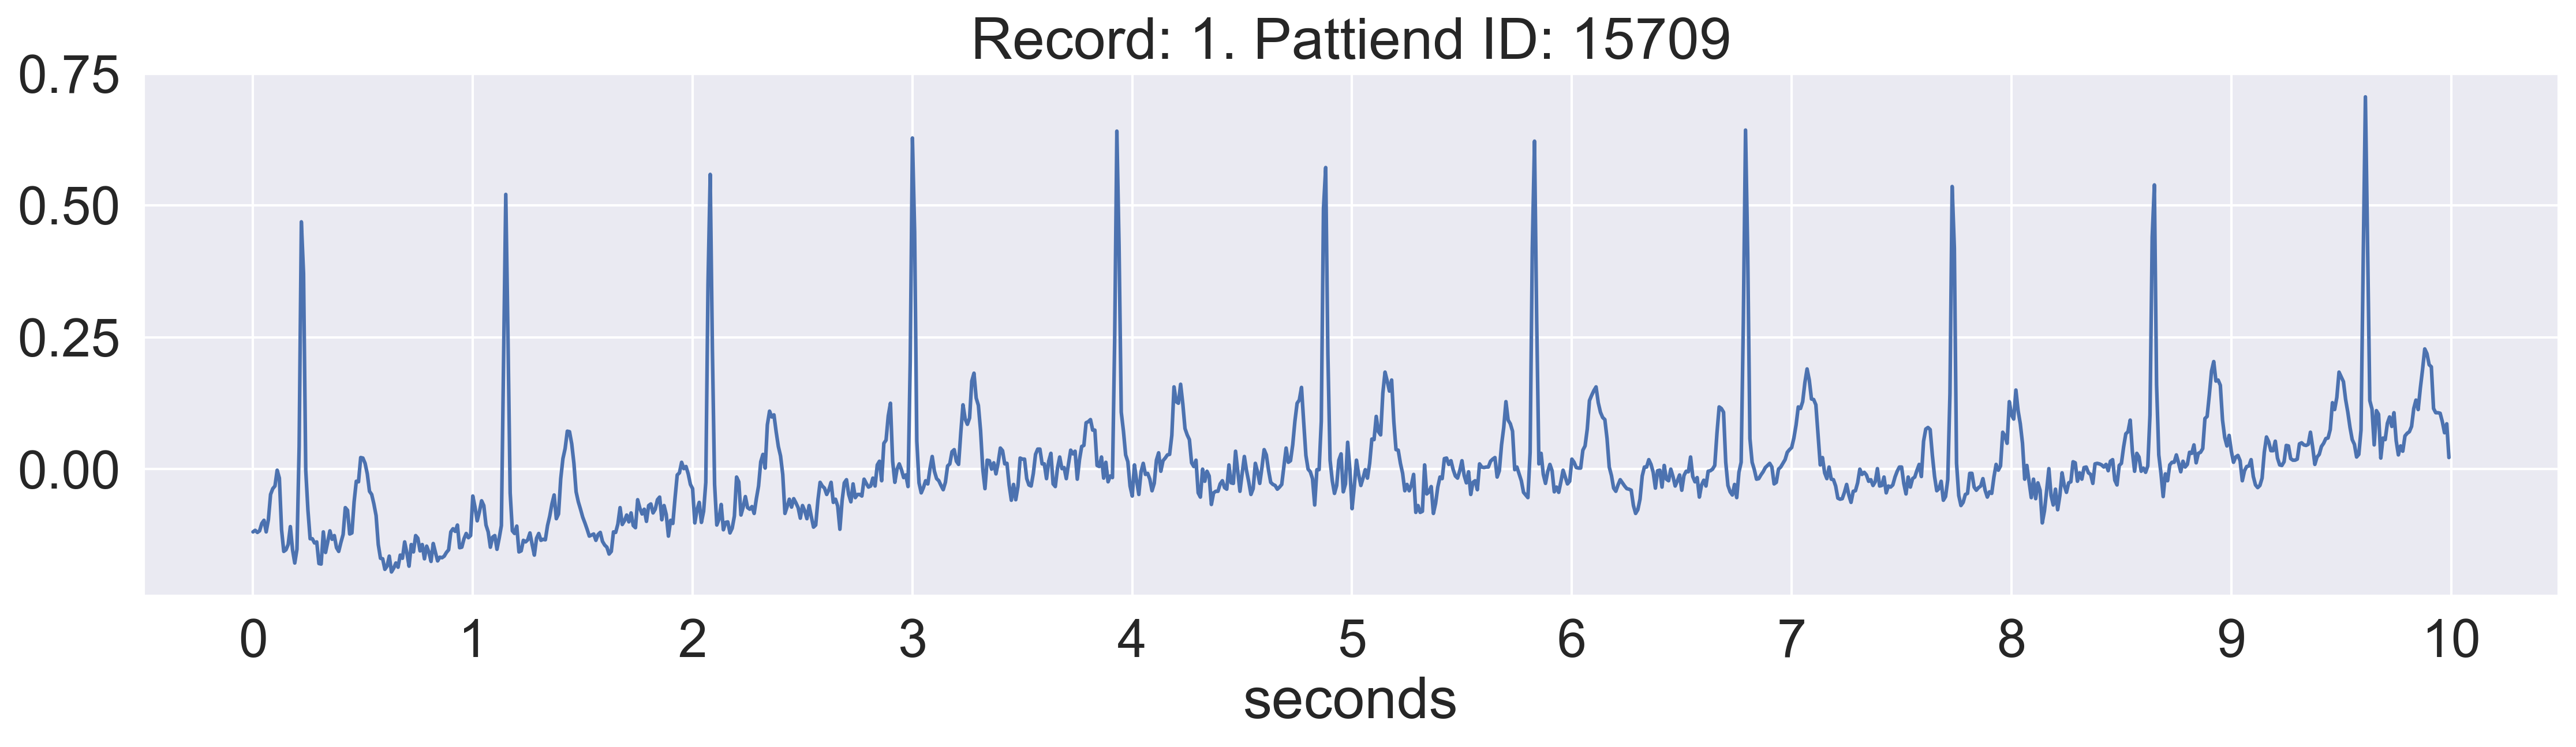

In [9]:
# patient index. it is used to work and plot as an example only one patient data
X_indx = 0

ecg_id = Y.index.tolist()
x_scale = list(range(0,11)) 
  
fig = plt.figure(figsize=(18, 4), dpi=300)
sns.set(font_scale=2)
sns.lineplot(data=X[X_indx,:,0]).set(xlabel='seconds', title=(f'Record: {1}. Pattiend ID: {Y.patient_id[ecg_id[X_indx]]}'))
plt.xticks(list(range(0,1100,100)), x_scale);

### Plot all 12 record from one patient, 12-lead ECG

In [10]:
x_scale = list(range(0,11))
sns.set(style='darkgrid')
sns.set(font_scale=3)

fig, ax = plt.subplots(3, 4, figsize=(40,20), dpi=300)
for i in range(ax.shape[1]):
    sns.lineplot(ax=ax[0, i], data=X[X_indx,:,i+1]).set(title=(f'Record: {i+1}')) 
    sns.lineplot(ax=ax[1, i], data=X[X_indx,:,i+4]).set(title=(f'Record: {i+5}'))
    sns.lineplot(ax=ax[2, i], data=X[X_indx,:,i+8]).set(title=(f'Record: {i+9}'))
    for j in range(ax.shape[0]):
        ax[j, i].set(xticks=list(range(0,1100,100)), xticklabels=x_scale)
        ax[j, i].set(xlabel='seconds')

    fig.tight_layout()
    
# open the figure in a separate window, not in Jupiter, with the ability to enlarge and look at them closer   
plt.savefig(f'ECG_patient_{X_indx}')

## 3. Identify the heart beat of the signal, average and total heart beat in the signal

As an illustration of the solutions, it was chosen the first patient and the first record. Otherwise, I would make one function with Y input and the required parameters, the heart beat of the signal, average and total heart beat,  as the output.

In [11]:
r_peaks_all = []
for i in range(X.shape[0]): 
    r_peaks_all.append([])
    r_tempr = []
    p = Y.r_peaks[ecg_id[i]]
    w = p.split(' ')
    removetable = str.maketrans('', '', "][\n")
    r_tempr = [s.translate(removetable) for s in w]
    r_tempr = filter(None, r_tempr) # remove all empty cells
    r_tempr = list(map(int, r_tempr))
    r_peaks_all[i].append(r_tempr)

The str.maketrans() static method is a helpful tool to produce the translation map; the first two arguments are empty strings because you are not replacing characters, only removing. The third string holds all characters you want to remove.

### Plot R_peaks

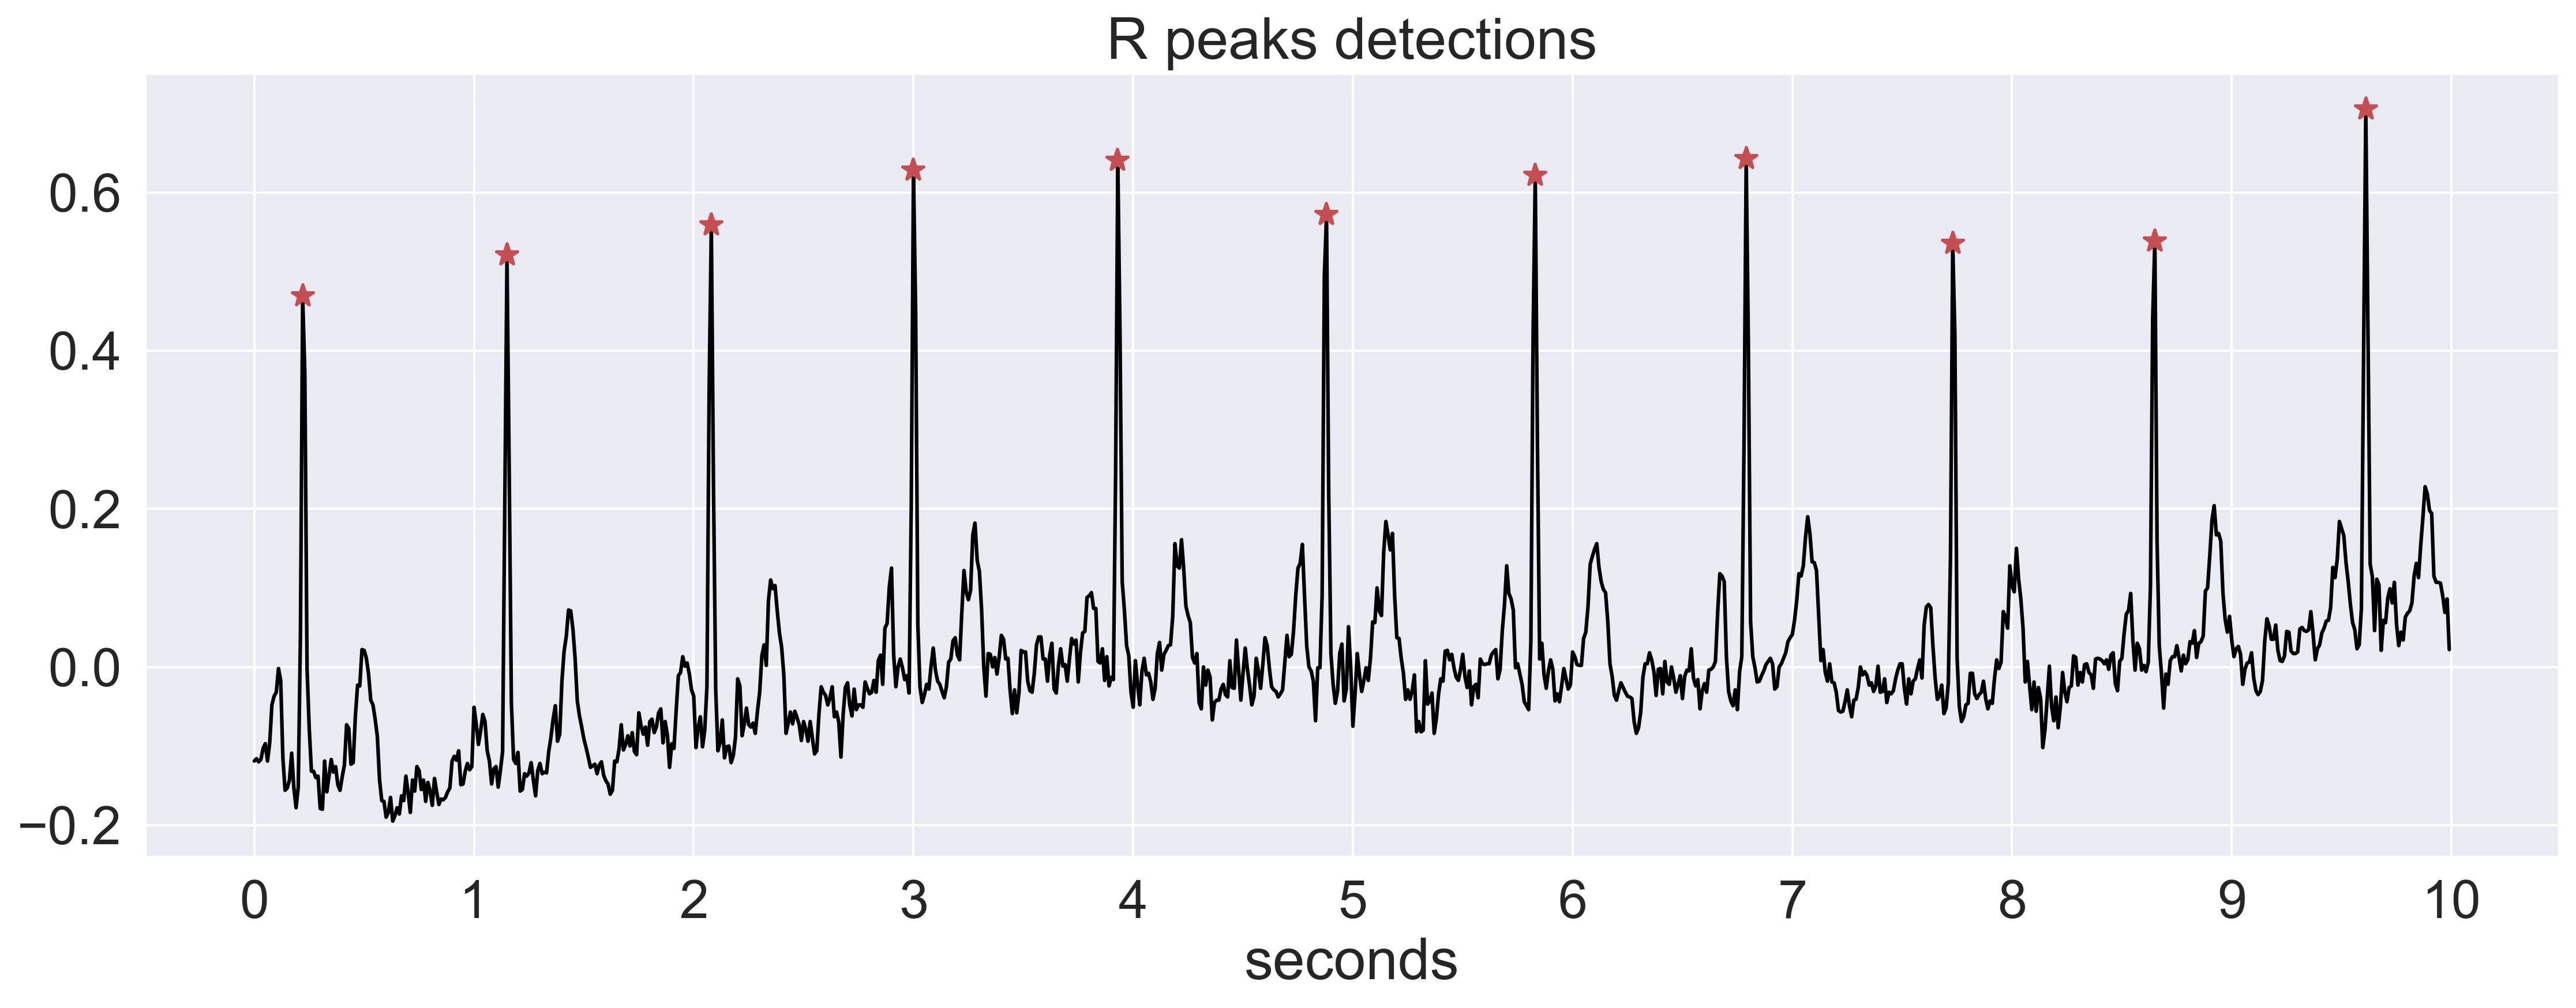

In [12]:
# one patiend with the first record
x = X[X_indx,:,0]
series = np.array(range(0,x.size+1))
sns.set(font_scale=2)

fig = plt.figure(figsize=(18, 6), dpi=300)
sns.lineplot(data=x, color='black').set(xlabel='seconds', title=('R peaks detections'))
plt.plot(series[r_peaks_all[X_indx][0]], x[r_peaks_all[X_indx][0]], 'r*', markersize=10)
plt.xticks(list(range(0,1100,100)), x_scale);


In this and next section, it has tasks to work with ECG wave. For convenience, schematic representation of a normal sinus rhythm ECG wave is plotted here:

<img src=https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg width=500, height=500>

### Total heart beat in the signal

R-peaks were labeled and included in 'ptbxl' database file. Length of an array, in this solution 'peaks', represent number of total hear beats.

In [13]:
N_r_peaks = []
for i in range(X.shape[0]):
    N_r_peaks.append(len(r_peaks_all[i][0])-1)
min(N_r_peaks)

4

### Average heart beat in the signal

More research is required to understand meanning ofr average heartbeat. For now, assume to take average of R-peaks.

In [14]:
np.average(x[r_peaks_all[X_indx][0]])

0.5850909090909091

## 4. Identify the complex QRS in the signal and been able to annotate on it

The next step is to identify the QRS wave complex. Let's smooth the data to detect Q and S waves and avoid mislabelling due to noise.

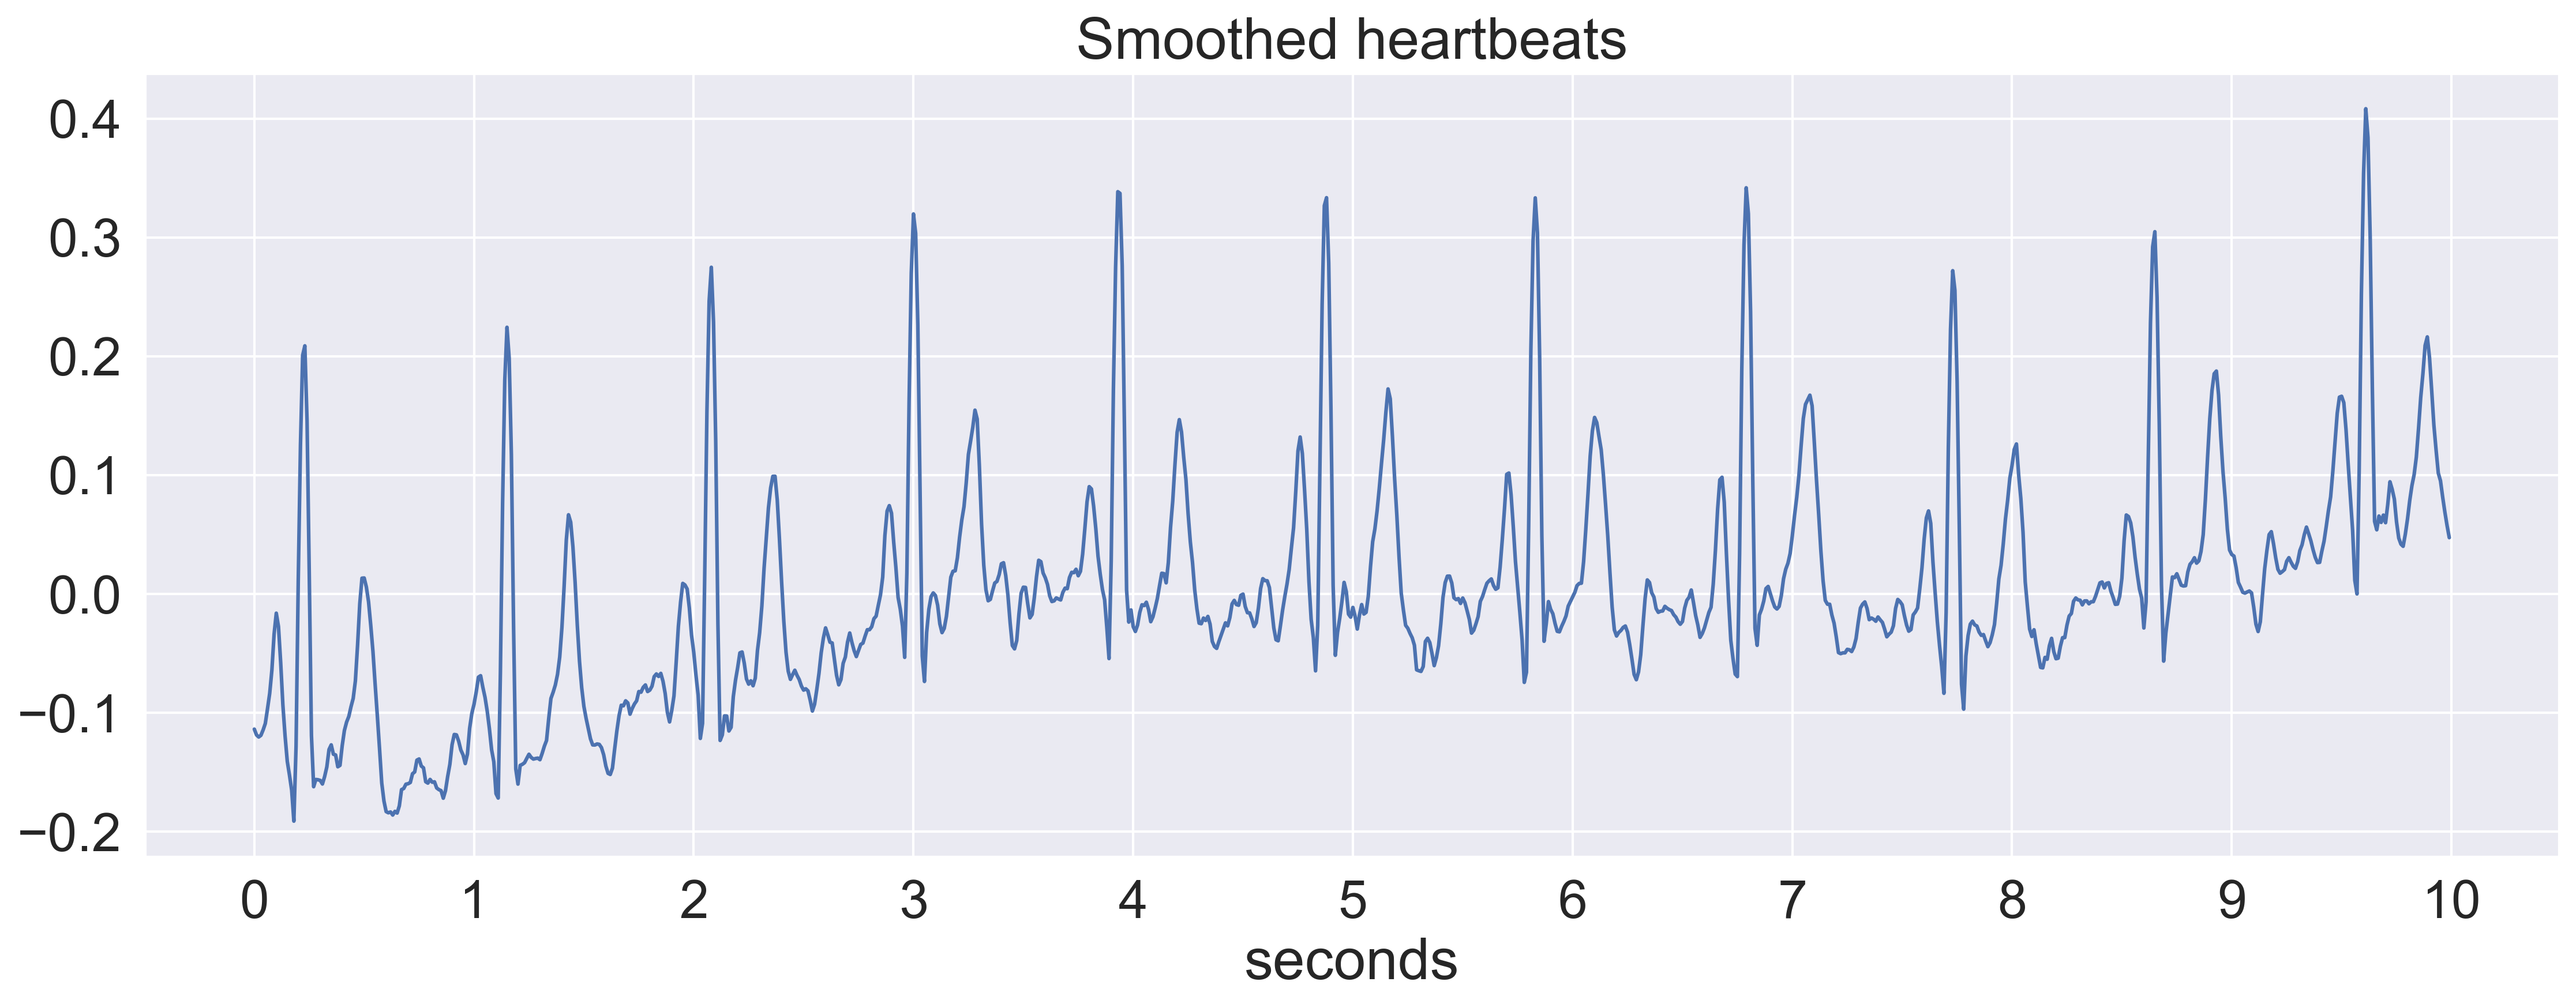

In [15]:
fig = plt.figure(figsize=(18, 6), dpi=300)
smoothed_heartbeats = scipy.signal.savgol_filter(x, window_length=9, polyorder=2)
smoothed_heartbeats = pd.Series(smoothed_heartbeats)
smoothed_heartbeats.plot()
plt.title('Smoothed heartbeats')
plt.xlabel('seconds')
plt.xticks(list(range(0,1100,100)), x_scale);

In [16]:
q_peaks = []
s_peaks = []
r_peaks = []

# CHANGE 18 TO X.shape[0] !!!!!!!!!!
for i in range(X.shape[0]):
    q_tempr = []
    s_tempr = []
    r_tempr = []

    q_peaks.append([])
    s_peaks.append([])
    r_peaks.append([])
    
    index_range = len(smoothed_heartbeats) # helps us not overshoot last element's index

    smoothed_heartbeats = scipy.signal.savgol_filter(x, window_length=9, polyorder=2)
    smoothed_heartbeats = pd.Series(smoothed_heartbeats)

    # adds a separate index number to each R-peak
    r_peaks_indx = enumerate(r_peaks_all[i][0])  
    for (index, r) in r_peaks_indx:
        start_index = r # exclude when he firs R-peak is too close to 0 and doesn't have Q-peak
        try:
            end_index = r_peaks_all[i][0][index + 1] # the next R-peak
        except IndexError:
            end_index = index_range        # have hit the end of the heartbeat array
        temp_rr_interval = smoothed_heartbeats[start_index:end_index]
        
        # Label the Q wave
        q_area = temp_rr_interval[-15:]
        q_area = pd.Series(q_area)
        q_peak = q_area.idxmin(axis=0)
        
        # Label the S wave
        s_area = temp_rr_interval[0:15]
        s_area = pd.Series(s_area)
        s_peak = s_area.idxmin(axis=0)

        q_tempr.append(q_peak) 
        s_tempr.append(s_peak)
    
    # drop last element because the end is temp_rr_interval is not the the next R-peask, 
    # it's end of the signal
    q_tempr = q_tempr[:-1]
    s_tempr = s_tempr[1:]
    r_tempr = r_peaks_all[i][0]
    r_tempr = r_tempr[1:]
    
    q_peaks[i].append(q_tempr)
    s_peaks[i].append(s_tempr)
    r_peaks[i].append(r_tempr)

This solution drops the first R-peak, q-peak and the last s-peak to avoid not completing a QRS wave. Another possible solution is always to check if the first QRS wave has all three peaks and is not being dropped by default.

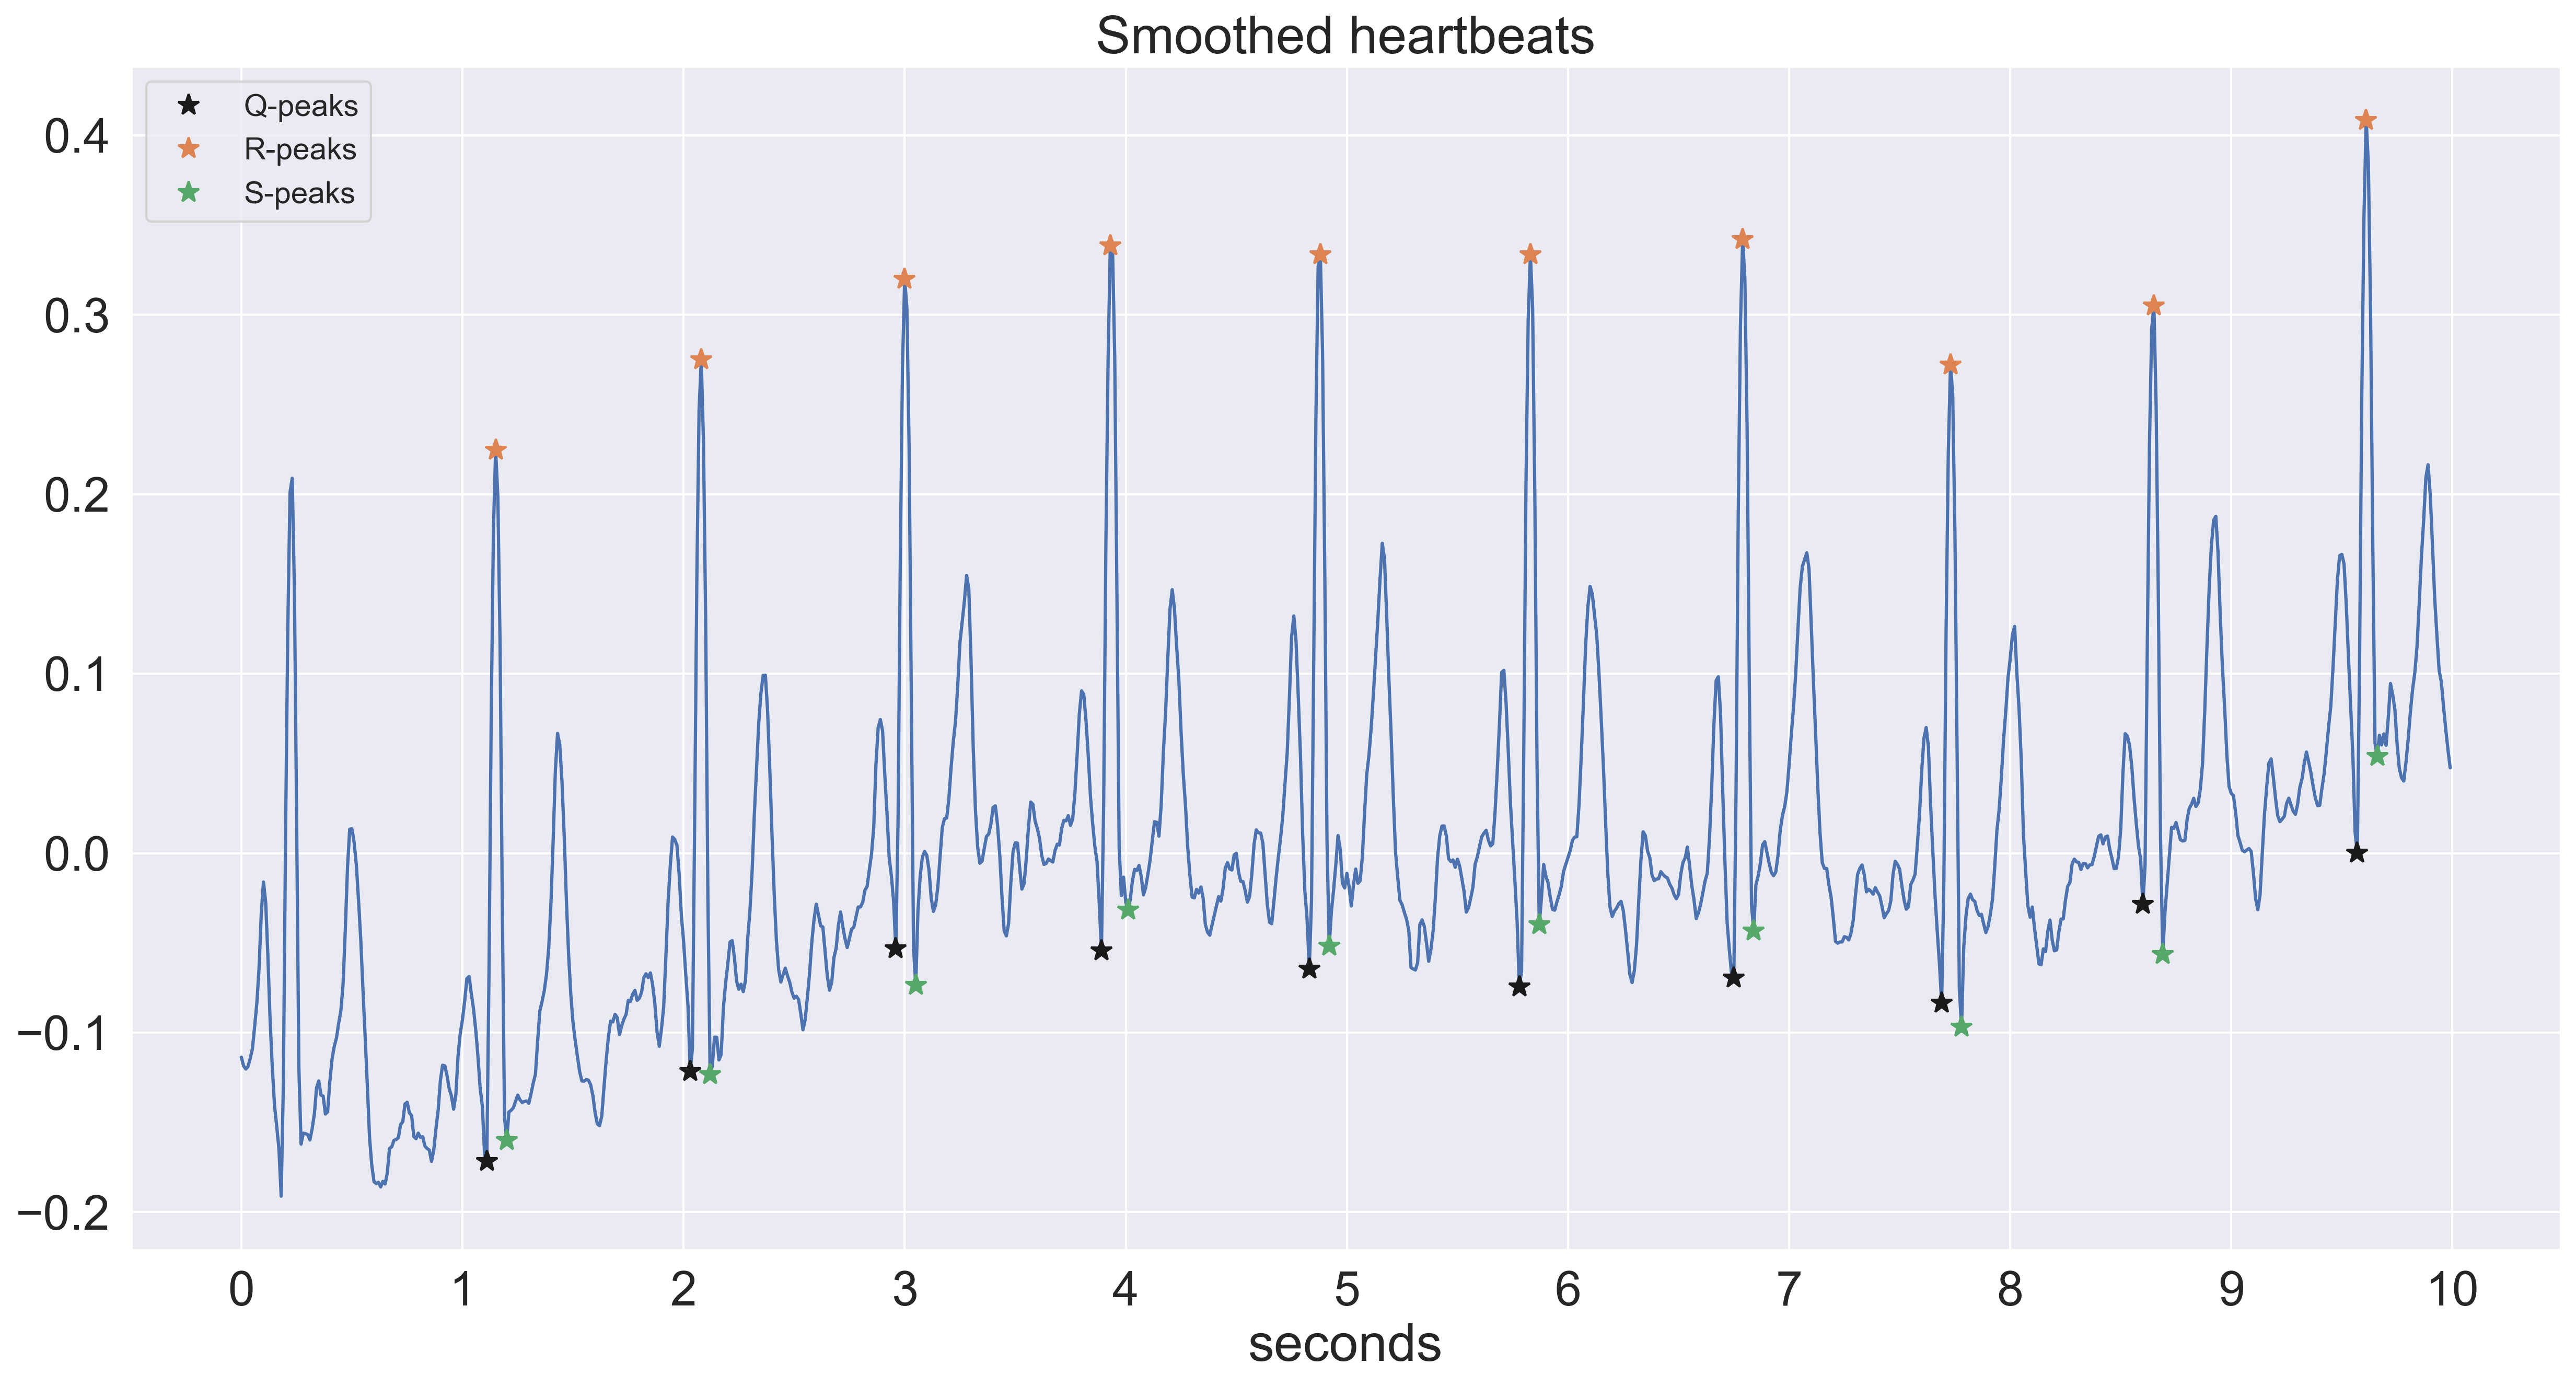

In [17]:
fig = plt.figure(figsize=(20, 10), dpi=300)
smoothed_heartbeats.plot()

plt.plot(q_peaks[X_indx][0], smoothed_heartbeats[q_peaks[X_indx][0]].values, 'k*', label='Q-peaks', markersize=10)
plt.plot(r_peaks[X_indx][0], smoothed_heartbeats[r_peaks[X_indx][0]].values, '*', label='R-peaks', markersize=10)
plt.plot(s_peaks[X_indx][0], smoothed_heartbeats[s_peaks[X_indx][0]].values, 'g*', label='S-peaks', markersize=10)
plt.legend(prop={'size': 14})
plt.title('QRS peaks')

plt.title('Smoothed heartbeats')
plt.xlabel('seconds')
plt.xticks(list(range(0,1100,100)), x_scale);

Since the data in the figure above is smoothed, for other patients, plots of r-peaks might be no in the exact same position because the smoothing function can shift picks.

In [18]:
QRS_waves = []
for i in range(X.shape[0]):
    QRS_waves.append([])
    for  j in range(min(N_r_peaks)):
        QRS_waves[i] += list(X[i,r_peaks[i][0][j]-5:r_peaks[i][0][j]+5,0])
QRS_waves = np.array(QRS_waves, dtype=object)

In [19]:
QRS_waves.shape

(21801, 40)

If to have all QRS waves then data is uneven which makes not possible run some ML models, Estimator expected <= 2. Since there are much daa it possible to drop some and have minimum of existing QRS waves amoung all patients.

In [20]:
Y.diagnostic_superclass[15:20]

ecg_id
16    [NORM]
17        []
18        []
19    [NORM]
20        []
Name: diagnostic_superclass, dtype: object

#### Some patients have no diagnostic superclass which causes the error 'Unknown label type: 'unknown'v'. Will fill the null values with "No_class"

In [21]:
Y.diagnostic_superclass = Y.diagnostic_superclass.apply(lambda y: ['No_class'] if len(y)==0 else y)

Convert Y.diagnostic superclass, labels, to string to be able to fit a ML model, otherwise it gives an error 'unknown' labels.

In [22]:
Y.diagnostic_superclass = Y.diagnostic_superclass.apply(lambda x: ', '.join(x))

In [23]:
Y.diagnostic_superclass[15:20]

ecg_id
16        NORM
17    No_class
18    No_class
19        NORM
20    No_class
Name: diagnostic_superclass, dtype: object

In [24]:
# Split data into train and test
test_fold = 10

# Test
X_test = QRS_waves[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

# Train
X_train = QRS_waves[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

### Train the models

### Random forest

In [33]:
# Import training classifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with n number of decision trees
model_RF = RandomForestClassifier(n_estimators = 70, random_state = 75)

# Train the model on training data
model_RF.fit(X_train, y_train);

#### Find optimal parameters for Random forest

In [32]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'n_estimators': [5, 10, 20, 50, 65, 70, 75, 100],
              'random_state': [1, 2, 5, 10, 20, 50, 65, 70, 75, 100]
             }
grid = RandomizedSearchCV(model_RF, parameters, n_iter=5, cv=5, n_jobs=4, verbose=2)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.8min finished


{'random_state': 75, 'n_estimators': 70}


### Accuracy check

In [34]:
from sklearn import metrics
prediction_test = model.predict(X_test)

##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.47042766151046406


Accuracy is quite low. Need to ry other models.

### Naive Bayes 

In [40]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
result_NB = model_NB.predict(X_test)

prediction_test_NB = model_NB.predict(X_test)

##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test_NB))

Accuracy =  0.24249317561419473


### K-nearest neighbors vote

In [41]:
from sklearn.neighbors import KNeighborsClassifier
model_KN = KNeighborsClassifier(n_neighbors=6)
model_KN.fit(X_train, y_train)
result_KN = model_KN.predict(X_test)

prediction_test_KN = model_NB.predict(X_test)

##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test_KN))

Accuracy =  0.24249317561419473


Since raditionally useds models didn't give promising resukts further

### TODO list

 - Balance classes, becausse class HYP is almost 4 imes smaller than NORM
 - Run a DCCNN model
 - Evaluate with bias and variance
 - Check confusion matrix and F1 parameter